# Выпускной проект "Исследование оттока клиентов Метанпромбанка"

**Объект исследования** – данные о клиентах банка «Метанпром»

**Цель проекта** – изучение предпоссылок и выделение сегментов клиентов, которые склонны уходить из банка

**Входные данные** — информация о киентах банка (файл bank_scrooge.csv), которая содержит принадлежность к филиалу банка (город), описательные данные клиентов и их банковскую историю

В процессе работы будут реализованы следующие шаги (декомпозиция проекта):

1. Загрузка и знакомство с данными
2. Предобработка данных
- проверка и изменение типов данных при необходимости/переименование названий столбцов;
- проверка на явные и неявные дубликаты;
- выявление и обработка пропусков;
- создание дополнительных столбцов (кодирование)
3. Исследовательский анализ данных
- исследование распределения признаков оттока клиентов;
- анализ портретов типичных клиентов, которые склонны и не склонны уходить из банка;
- корреляционный анализ;
- промежуточные итоги и выводы по результатам EDA.
4. Формирование и проверка статистических гипотез
- гипотеза 1 о влиянии доходов клиентов на отток;
- проверка иных гипотез по результатам EDA;
- промежуточные выводы по результатам статистического анализа данны
5. Сегментация
6. Приоритизация сегментов
7. Формирование итоговых выводов и рекомендаций

## Загрузка и знакомство с данными

In [1]:
# импорируем библиотеки

import pandas as pd
from scipy import stats as st
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plotly import graph_objects as go
import plotly.express as px
import os

In [2]:
# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
#загружаем данные

data = pd.read_csv('/datasets/bank_scrooge.csv')

In [4]:
# получаем информацию и представление о таблице
data.info()

data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.00,Рыбинск,Ж,25.00,1,"59,214.82",2,0,1,"75,719.14",1
1,146556,861.00,Рыбинск,Ж,37.00,5,"850,594.33",3,1,0,"86,621.77",0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,"107,683.34",0
3,225363,866.00,Ярославль,Ж,51.00,5,"1,524,746.26",2,0,1,"174,423.53",1
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,"67,353.16",1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.00,Рыбинск,М,27.00,1,"78,144.65",1,0,1,"18,943.64",0
9996,139170,894.00,Ярославль,М,46.00,0,NaN,1,1,0,"196,898.29",0
9997,115639,903.00,Ярославль,М,24.00,0,NaN,2,1,1,"108,905.09",0
9998,148700,777.00,Ярославль,Ж,68.00,3,"865,457.97",3,0,1,"86,874.90",0


Загружены данные, по первому знакомству можно сделать следующие **ВЫВОДЫ:**
- всего в датасете представлено 10000 записей, 12 столбцов с разной информацией
- требуется переименовать столбцы, привести к нижнему регистру
- типы данных столбцов соответствуют значениям
- в столбцах `age` и  `balance` есть пропуски, далее мы их изучим подробней

## Предобработка данных

### Переименование столбцов

In [5]:
# приведем названия столбцов к нижнему регистру и переименуем

data.columns = data.columns.str.lower()

data = data.rename(columns={'userid': 'user_id'})

data.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

### Проверка на дубликаты

In [6]:
#проверим данные на дубликаты

data.duplicated().sum()

0

In [7]:
# проверим на дубликаты по userid

data.duplicated(subset='user_id').sum()

73

In [8]:
# выведем их для ознакомления

data[data.duplicated('user_id',keep=False)].sort_values(by='user_id')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.00,Рыбинск,Ж,55.00,1,"362,756.49",3,0,1,"175,920.48",1
7694,116540,887.00,Ярославль,Ж,38.00,0,NaN,1,0,1,"119,247.61",0
7542,117943,880.00,Ярославль,Ж,40.00,0,NaN,1,1,0,"137,718.93",0
4866,117943,855.00,Рыбинск,Ж,32.00,6,"1,036,832.93",4,1,1,"107,792.71",1
5896,120258,905.00,Ярославль,М,30.00,0,NaN,1,1,1,"146,427.96",0
...,...,...,...,...,...,...,...,...,...,...,...,...
2597,226719,990.00,Ярославль,М,37.00,4,"14,648,692.14",2,0,0,"934,412.61",1
8205,227795,840.00,Рыбинск,М,34.00,2,"350,768.03",1,1,0,"102,036.14",1
8497,227795,839.00,Ярославль,М,34.00,2,"326,593.14",2,1,0,"103,314.92",0
6457,228075,839.00,Рыбинск,М,39.00,5,"507,199.85",3,0,1,"85,195.80",0


Мы видим, что дубликаты по `userid` представлены в разных городах. Подтвердим это срезами по городам.

In [9]:
# проверим дубликаты по userid на срезах по городам

print(data.query('city =="Рыбинск"').duplicated(subset='user_id').sum())

print(data.query('city =="Ярославль"').duplicated(subset='user_id').sum())

data.query('city =="Ростов"').duplicated(subset='user_id').sum()

0
0


0

Предположение верное, поэтому удалять их не будем, это может быть  связано с тем, что в разных городах может быть разная система учета и присвоения id клиентам (так как есть клиенты с одинаковым id, но критично разным возрастом). Информацию о том, является ли база клиентов единой по городам стоит уточнить. 

In [10]:
# проверим некоторые столбцы на неявные дубликаты и представленные уникальные значения 

print(f"Город: {data['city'].unique()}")
print()
print(f"Пол: {data['gender'].unique()}")
print()
print(f"Наличие кредитной карты: {data['credit_card'].unique()}")
print()
print(f"Активность клиента: {data['last_activity'].unique()}")
print()
f"Отток клиентов: {data['churn'].unique()}"
print()
f"Количество продуктов: {data['products'].unique()}"

Город: ['Рыбинск' 'Ярославль' 'Ростов']

Пол: ['Ж' 'М']

Наличие кредитной карты: [0 1]

Активность клиента: [1 0]




'Количество продуктов: [2 3 1 4 5 0]'

Представлены 3 города - Рыбинск, Ярославль, Ростов; неявных дубликатов не выявлено.

Отметим, что есть клиенты с нулевым количеством продуктов, это аномалия, посмотрим на количество таких записей.

In [11]:
data.query('products == 0')['user_id'].count()

1

Только одна запись, скорее всего техническая ошибка, можем удалить ее из базы.

In [12]:
data = data.query('products > 0')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9999 non-null   int64  
 1   score          9999 non-null   float64
 2   city           9999 non-null   object 
 3   gender         9999 non-null   object 
 4   age            9973 non-null   float64
 5   equity         9999 non-null   int64  
 6   balance        7705 non-null   float64
 7   products       9999 non-null   int64  
 8   credit_card    9999 non-null   int64  
 9   last_activity  9999 non-null   int64  
 10  est_salary     9999 non-null   float64
 11  churn          9999 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 1015.5+ KB


### Обработка пропусков

In [13]:
# посмотрим процент пропусков

(data.isna().mean()*100).sort_values()

user_id          0.00
score            0.00
city             0.00
gender           0.00
equity           0.00
products         0.00
credit_card      0.00
last_activity    0.00
est_salary       0.00
churn            0.00
age              0.26
balance         22.94
dtype: float64

По столбцу `age` пропусков всего 0,3%, поэтому можно их удалить

In [14]:
data = data.dropna(subset=['age']).reset_index(drop=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9973 entries, 0 to 9972
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9973 non-null   int64  
 1   score          9973 non-null   float64
 2   city           9973 non-null   object 
 3   gender         9973 non-null   object 
 4   age            9973 non-null   float64
 5   equity         9973 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9973 non-null   int64  
 8   credit_card    9973 non-null   int64  
 9   last_activity  9973 non-null   int64  
 10  est_salary     9973 non-null   float64
 11  churn          9973 non-null   int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 935.1+ KB


По столбцу `balance` пропусков 23%, выясним их зависимость от данных

In [15]:
# создадим новый столбец и присвоем признак 1 для пропущенных значений и 0 для иных

data['balance_na'] = np.where(data['balance'].isnull(),1,0)

data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_na
0,183012,850.00,Рыбинск,Ж,25.00,1,"59,214.82",2,0,1,"75,719.14",1,0
1,146556,861.00,Рыбинск,Ж,37.00,5,"850,594.33",3,1,0,"86,621.77",0,0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,"107,683.34",0,1
3,225363,866.00,Ярославль,Ж,51.00,5,"1,524,746.26",2,0,1,"174,423.53",1,0
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,"67,353.16",1,0


In [16]:
# построим сводную таблицу для определения зависимостей по другим столбцам
#сначала по числовым

agg_func = {"score": 'mean',"age": 'mean',
                           "equity": 'median',
                           "products": 'median',"credit_card": 'median',
                           "last_activity": 'median',"est_salary": 'mean'}

piv_balance_na = data.pivot_table(columns='balance_na',
                   values=['score','age','equity',
                           'products','credit_card',
                           'last_activity','est_salary'],
                   aggfunc=agg_func)

piv_balance_na.columns = [ 'fill', 'miss']

piv_balance_na['diff_per'] = piv_balance_na['miss']/piv_balance_na['fill']-1

piv_balance_na

,fill,miss,diff_per
age,42.92,42.08,-0.02
credit_card,1.00,1.00,0.00
equity,4.00,0.00,-1.00
est_salary,"124,520.39","226,433.78",0.82
last_activity,1.00,1.00,0.00
products,2.00,1.00,-0.50
score,843.74,865.31,0.03


In [17]:
# теперь еще одну сводную таблицу по строковым

piv_balance_na_plus = data.pivot_table(columns='balance_na',values=['gender','city'],
                   aggfunc={"gender": pd.Series.mode,"city": pd.Series.mode})

piv_balance_na_plus.columns = [ 'fill', 'miss']

In [18]:
# склеим таблицы

piv_balance_na = piv_balance_na.append(piv_balance_na_plus)

piv_balance_na

,fill,miss,diff_per
age,42.92,42.08,-0.02
credit_card,1.00,1.00,0.00
equity,4.00,0.00,-1.00
est_salary,"124,520.39","226,433.78",0.82
last_activity,1.00,1.00,0.00
products,2.00,1.00,-0.50
score,843.74,865.31,0.03
city,Ярославль,Ярославль,NaN
gender,Ж,М,NaN


Из таблицы видно, что разница существенна по столбцам `equity`, `est_salary` и `products`. Посмотрим еще на распределение по полу. Для более подробного выяснения рассчитаем коэффициент корреляции методом Пирсона, также посмотрим по отдельным показателям количество записей в долях.

In [19]:
# смотрим количество записей

for i in ['equity','products','gender']:
    print(data.groupby([i]) ['balance_na'].value_counts(normalize=True))
    print('')

equity  balance_na
0       1            0.84
        0            0.16
1       0            0.85
        1            0.15
2       0            1.00
3       0            1.00
4       0            1.00
5       0            1.00
6       0            1.00
7       0            1.00
8       0            1.00
9       0            1.00
Name: balance_na, dtype: float64

products  balance_na
1         1            0.58
          0            0.42
2         0            0.94
          1            0.06
3         0            0.97
          1            0.03
4         0            1.00
5         0            1.00
Name: balance_na, dtype: float64

gender  balance_na
Ж       0            0.80
        1            0.20
М       0            0.75
        1            0.25
Name: balance_na, dtype: float64



Действительно по собственности явно выражена взаимосвязь - если нет объектов, то нет данных по балансу. По продуктам тоже есть зависимость. у клиентов с 1 продуктом больше пропусков - если 1 продукт, это может быть кредитная карта, которая не активирована или нестандартные услуги банка типа страховки и пр., где не требуется наличие в данном банке баланса. А вот по полу мы видим, что процент пропущенных значений практически идентичен по мужчинам и женщинам.
Требуется еще проверить средний доход, сделаем это через коэффициент корреляции и заодно другие тоже параметры посмотрим.

In [20]:
#корреляция (method='pearson')

for i in ['equity','products',
          'est_salary']:
    print(f"Корреляция с  {i} составляет: {data[i].corr(data['balance_na'])}")

Корреляция с  equity составляет: -0.7091912390834717
Корреляция с  products составляет: -0.48601481763595394
Корреляция с  est_salary составляет: 0.3071832439811159


Корреляция с `est_salary`есть, но не очень сильная. В таблице мы рассчитывали доход по среднему значению, возможно в данных есть выбросы, которые исказили ситуацию. Это мы увидим при проведении анализа данных.

В целом по пропускам мы выяснили, что пропуски не являются случайными и зависят от ряда данных, их нельзя отбрасывать или заполнять одним значением, т.к. это приведёт к заметным искажениям.

### Кодирование столбцов

Для дальнейшего проведения EDA закодируем категориальные переменные. К ним относятся пол и город.

In [21]:
# чтобы не пропали исходные столбцы создадим новые дополнительные

data['city_code'] = data['city']
data['gender_code'] = data['gender']

#кодируем
data = pd.get_dummies(data, columns=['city_code','gender_code'])

data.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_na,city_code_Ростов,city_code_Рыбинск,city_code_Ярославль,gender_code_Ж,gender_code_М
0,183012,850.00,Рыбинск,Ж,25.00,1,"59,214.82",2,0,1,"75,719.14",1,0,0,1,0,1,0
1,146556,861.00,Рыбинск,Ж,37.00,5,"850,594.33",3,1,0,"86,621.77",0,0,0,1,0,1,0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,"107,683.34",0,1,0,1,0,1,0
3,225363,866.00,Ярославль,Ж,51.00,5,"1,524,746.26",2,0,1,"174,423.53",1,0,0,0,1,1,0
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,"67,353.16",1,0,0,0,1,0,1


### Вывод по разделу

Проведена предобработка данных: 
- наименования столбцов приведены к нижнему регистру;
- полных дубликатов нет, проверены дубликаты по `user_id`, оставлены без изменений, так как относятся к разным кородам;
- неявных дубликатов не выявлено;
- в данных представлены 3 города - Рыбинск, Ярославль, Ростов;
- устранена аномалия по количеству продуктов. Удалена из базы 1 запись с 0 кол-вом продуктов;
- обработаны пропуски:
  - пропуски выявлены в 2-х столбцах: `age` и `balance`;
  - в столбце `age` - 0,3% пропусков, удалены данные строки; 
  - в столбце`balance` - 23%, проведено исследование природы пропусков - являются MNAR, т.е. не являются случайными, зависят от данных, оставлены без изменений. Больше всего зависят от количества объектов собственности - по клиентам, у которых 0 объектов собственности 84% пропусков в записях о балансе. Также у клиентов всего с одним продуктом пропусков 58%;
- проведено кодирование категориальных переменных ля дальнейшего проведения EDA. К ним относятся пол и город.

## Исследовательский анализ данных

### Анализ распределения признаков оттока 

In [22]:
# выведем на экран наименования столбцов для удобства копирования

list(data.columns)

['user_id',
 'score',
 'city',
 'gender',
 'age',
 'equity',
 'balance',
 'products',
 'credit_card',
 'last_activity',
 'est_salary',
 'churn',
 'balance_na',
 'city_code_Ростов',
 'city_code_Рыбинск',
 'city_code_Ярославль',
 'gender_code_Ж',
 'gender_code_М']

count   9,973.00
mean      848.67
std        65.39
min       642.00
25%       802.00
50%       853.00
75%       900.00
max     1,000.00
Name: score, dtype: float64


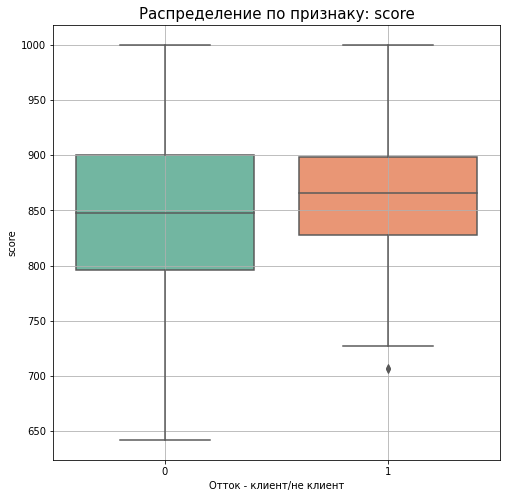

count   9,973.00
mean       42.73
std        12.18
min        18.00
25%        33.00
50%        40.00
75%        51.00
max        86.00
Name: age, dtype: float64


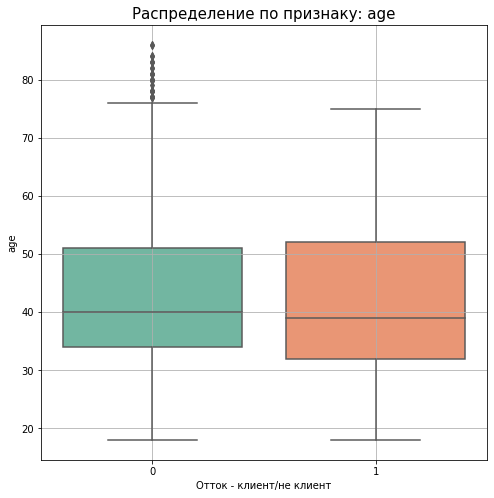

count         7,695.00
mean        827,245.59
std       1,980,327.41
min               0.00
25%         295,698.71
50%         524,295.33
75%         980,051.21
max     119,113,552.01
Name: balance, dtype: float64


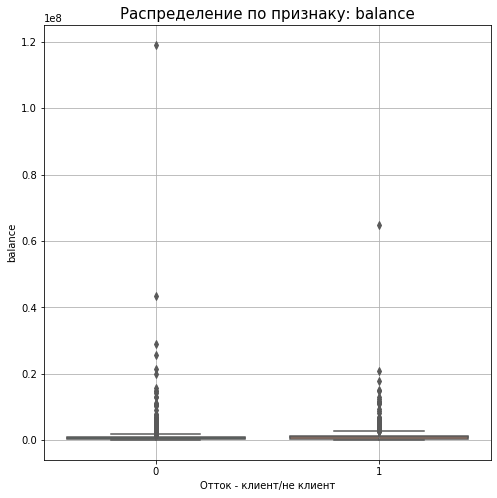

count       9,973.00
mean      147,799.12
std       139,287.08
min         2,546.30
25%        75,252.02
50%       119,643.06
75%       174,499.96
max     1,395,064.45
Name: est_salary, dtype: float64


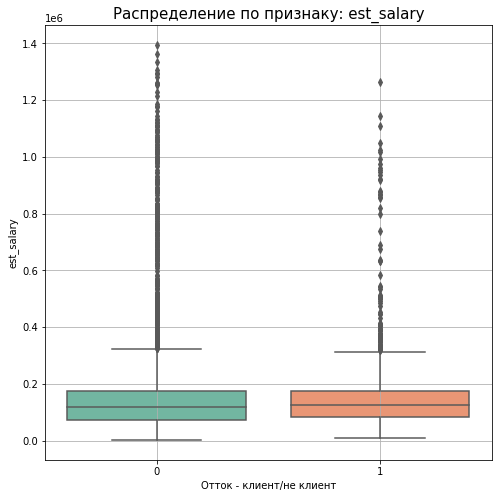

In [23]:
# посмотрим на выбросы по непрерывным данным

num = ['score','age','balance', 'est_salary']

for i in num:
    
    plt.figure(figsize=(8, 8))
    sns.boxplot(y = i, x = 'churn', data = data, palette = 'Set2')
    plt.grid()
    plt.title(f"Распределение по признаку: {i}", fontsize=15)
    plt.xlabel("Отток - клиент/не клиент")  
    print(data[i].describe())
    plt.show()

По `balance`и `est_salary` есть выбросы и существенные, однако удалять мы их не будем, так как такие цифры вполне могут быть. При дальнейшем анализе по ним будем использовать медиану, а не среднее. Для гистограмм обрежем данные по этим параметрам по 97 перцентилю.
Далее для анализа распределения построим гистограммы.

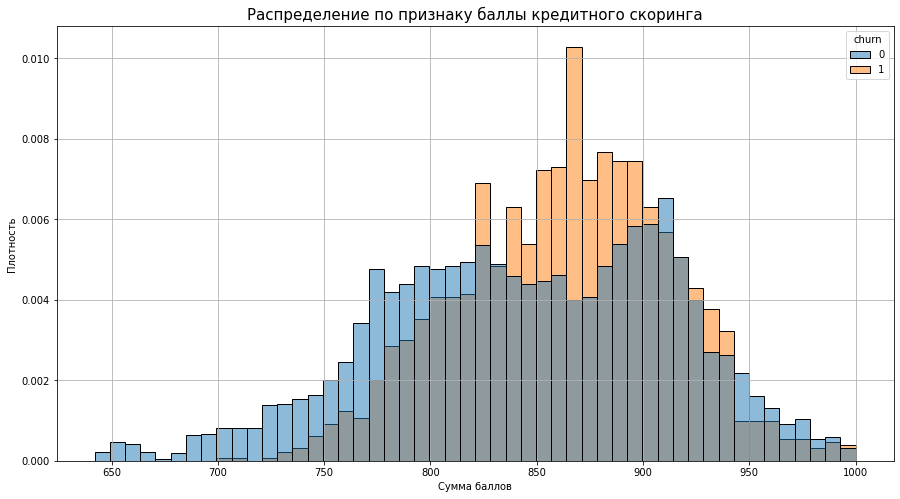

In [24]:
# гистограмма для 'score'

plt.figure(figsize=(15, 8))

sns.histplot(x = 'score', hue = 'churn',data=data, stat="density",common_norm=False,bins=50)

plt.grid()
plt.title('Распределение по признаку баллы кредитного скоринга', fontsize=15)
plt.xlabel('Сумма баллов')
plt.ylabel('Плотность') 

plt.show()
#binwidth=1 

Наибольший отток (превышение на гистограмме) показывают клиенты с суммой баллов от 830 до 900.

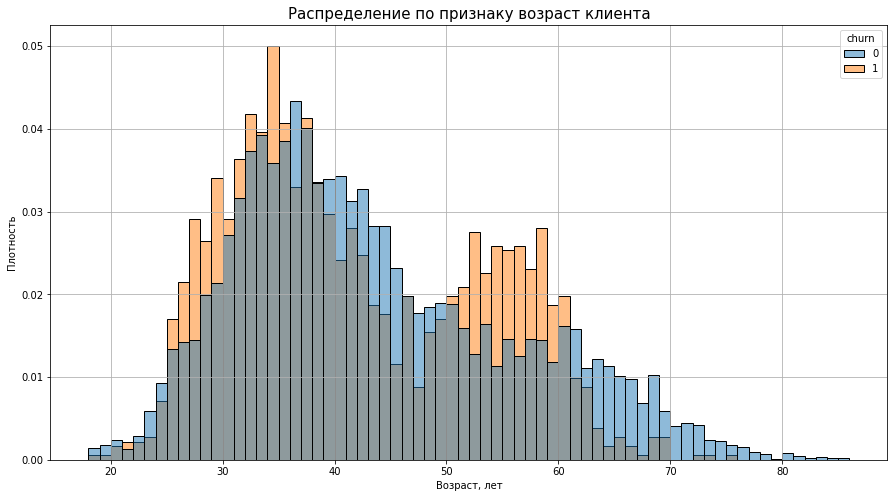

In [25]:
# гистограмма для 'age'

plt.figure(figsize=(15, 8))

sns.histplot(x = 'age', hue = 'churn',data=data,stat="density",common_norm=False,binwidth=1 )

plt.grid()
plt.title('Распределение по признаку возраст клиента', fontsize=15)
plt.xlabel('Возраст, лет')
plt.ylabel('Плотность')     

plt.show()
#binwidth=1  

Возраст клиентов, которые ушли из банка, имеет 2 интервала: с 26 до 36, с 50 до 60.

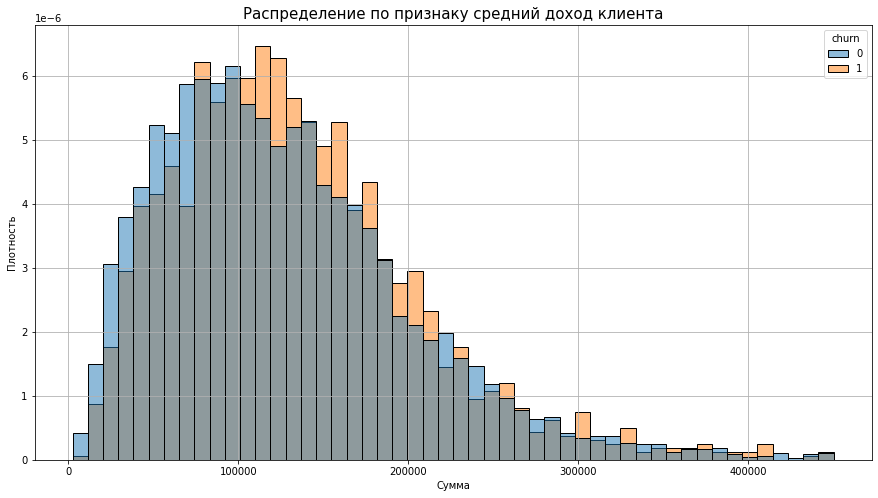

In [26]:
# гистограмма для 'est_salary'

salary_perc = np.percentile(data.est_salary,97)

plt.figure(figsize=(15, 8))
sns.histplot(x = 'est_salary', hue = 'churn',data=data.query('est_salary < @salary_perc'),
                                                            stat="density",common_norm=False,bins=50)
plt.grid()
plt.title('Распределение по признаку средний доход клиента', fontsize=15)
plt.xlabel('Сумма')
plt.ylabel('Плотность')   

plt.show()
#binwidth=1 bins=100  

Преимущественно средний доход клиентов, ушедших из банка, от 110 т.р. до 210 т.р.

In [27]:
# так как в столбце 'balance' есть пропуски, создадим новую data без пропусков, далее она нам тоже пригодится

data_balance = data.query('balance_na == 0')

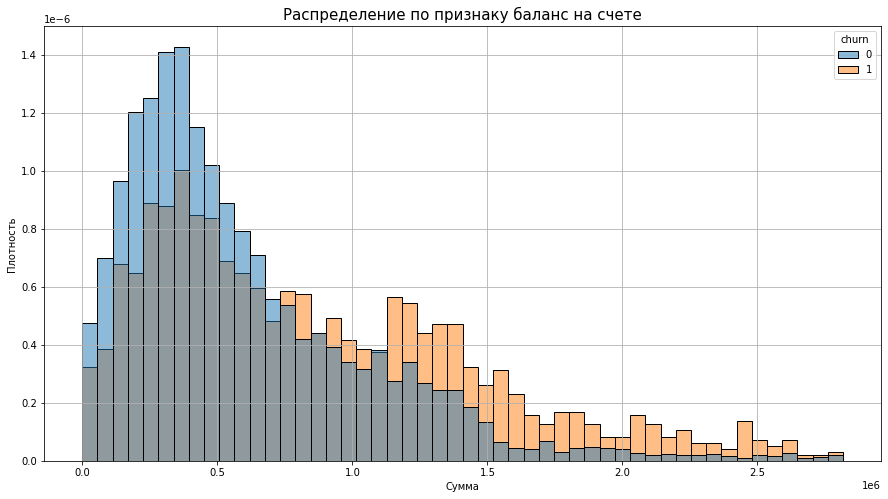

In [28]:
# гистограмма для 'balance'

balance_perc = np.percentile(data_balance.balance,97)

plt.figure(figsize=(15, 8))
sns.histplot(x = 'balance', hue = 'churn',data=data_balance.query('balance < @balance_perc'), 
             stat="density",common_norm=False,bins=50 )
plt.grid()
plt.title('Распределение по признаку баланс на счете', fontsize=15)
plt.xlabel('Сумма')
plt.ylabel('Плотность')   

plt.show()
#binwidth=1 

Наиболее интересующий нас интервал по отточным клиентам - от 700 т.р.

Далее построим визуализации по категориальным данным.

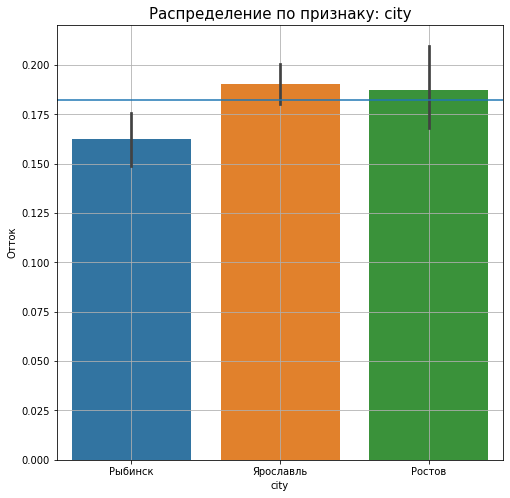

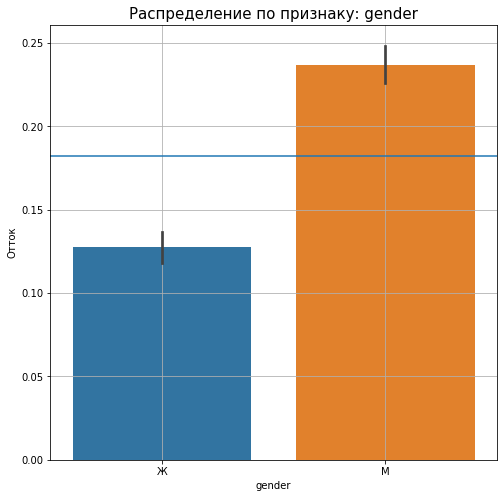

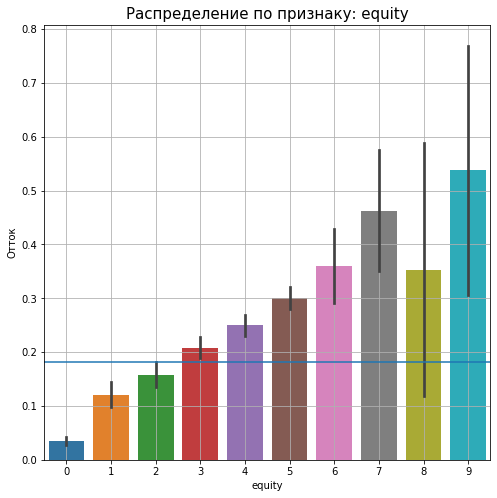

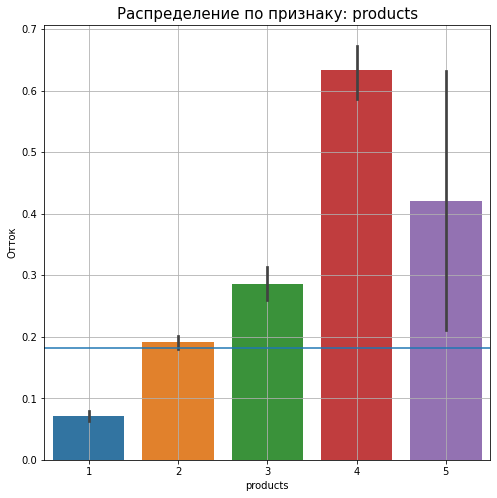

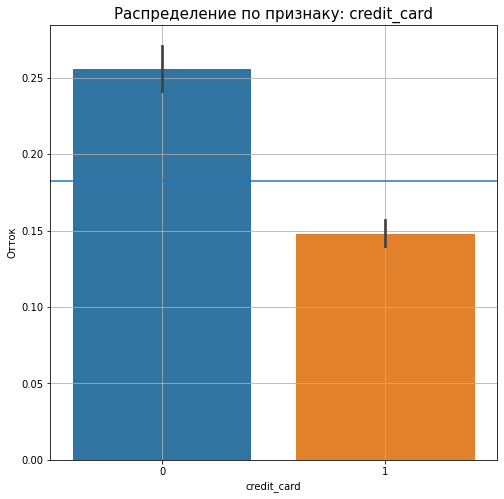

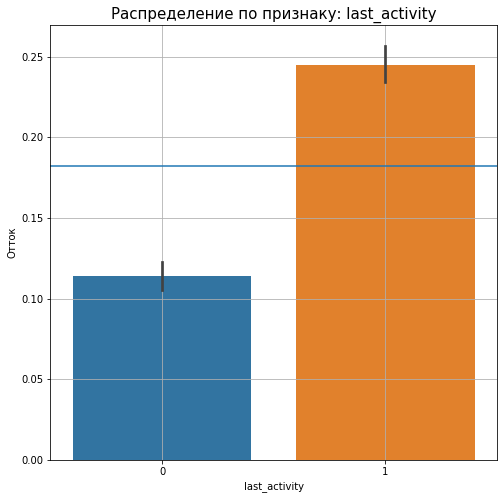

In [29]:
# используем цикл

cat = ['city','gender','equity','products','credit_card','last_activity']

for j in cat:
    
    plt.figure(figsize=(8, 8))
    sns.barplot(x = j, y = 'churn', data = data)
    plt.axhline(data['churn'].mean())
    plt.grid()
    plt.title(f"Распределение по признаку: {j}", fontsize=15)
    plt.ylabel("Отток")  
  
    plt.show()

Таким образом, для тех значений, где превышает среднее мы можем говорить, что эти признаки более склонны к оттоку:
- города Ярославль, чуть меньше Ростов
- мужчины более склонны, чем женщины
- количество объектов собственности - более 3
- количество продуктов - 0 или от 2
- не имеющие кредитную карту
- как ни странно, активные клиенты.

### Корреляционный анализ

In [30]:
#сделаем базу для корреляции, уберем ненужные столбцы

data_for_corr = data.drop(columns=['user_id','city','gender','balance_na']) 

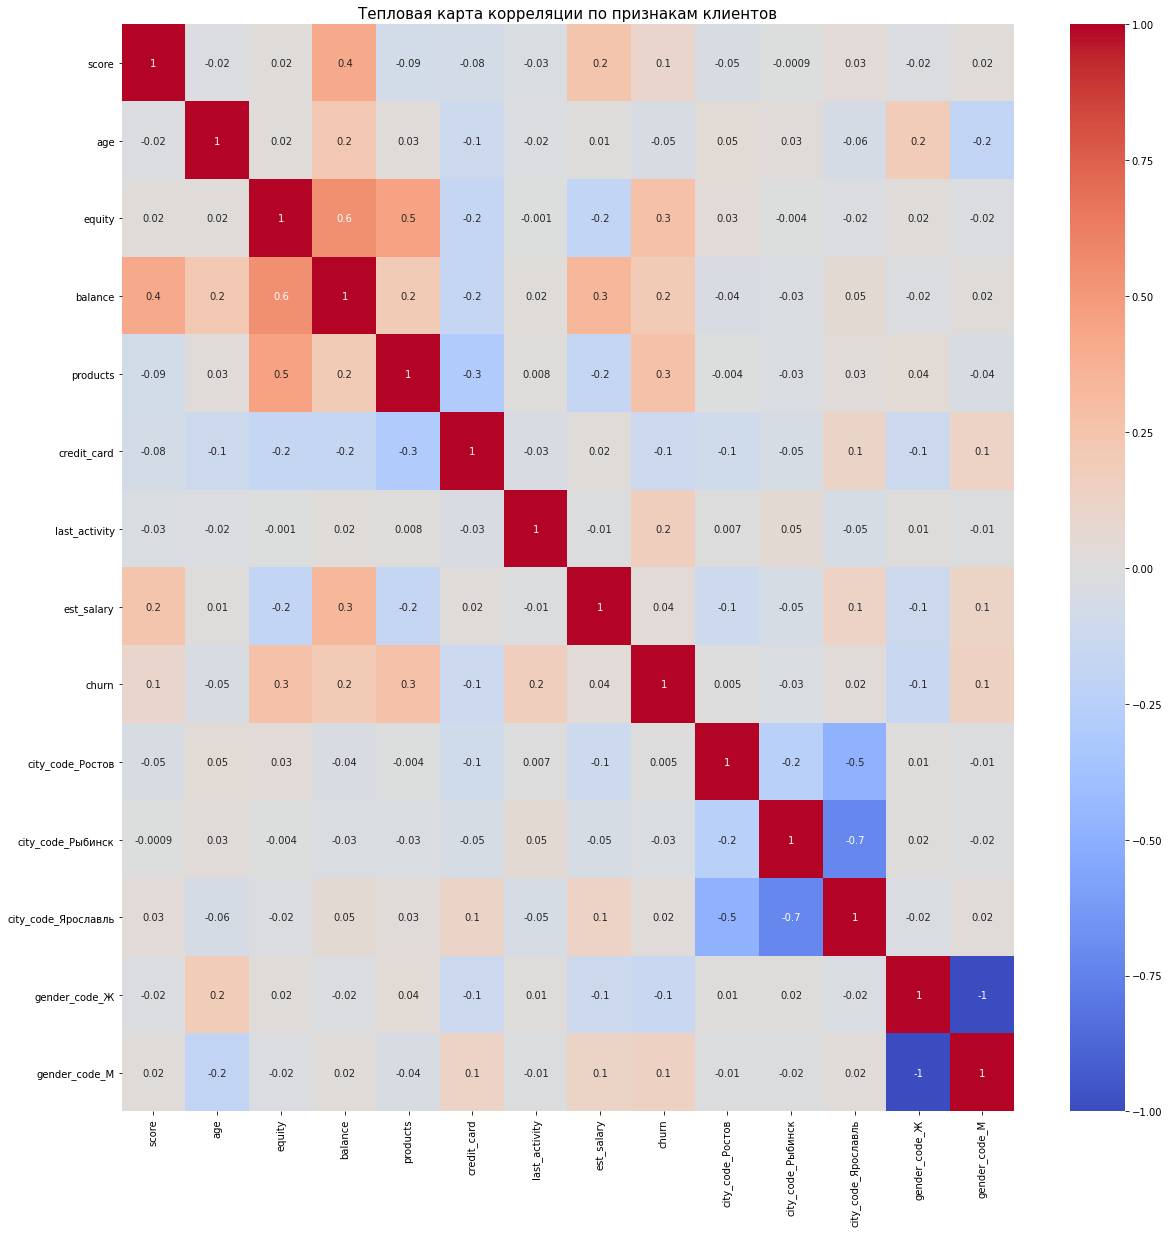

In [31]:
#построим тепловую кару корреляции, используем метод Спирмана,
#так как не все признаки имеют нормальное распредеение и представлены столбцы с категориальными значениями

plt.figure(figsize=(20, 20))

sns.heatmap(data_for_corr.corr(method='spearman'), annot=True, cmap='coolwarm',vmin=-1, vmax=1, center= 0, fmt='.1g')

plt.title(f"Тепловая карта корреляции по признакам клиентов", fontsize=15)
plt.show()

#linewidths=3  alpha=.5 fmt='.2g'

Видна зависимость, хотя и слабая, по 4 признакам `equity`,`balance`,`products`, `last_activity`

### Анализ портретов типичных клиентов, которые склонны и не склонны уходить из банка

In [32]:
#построим сводные таблицы и рассчитаем относительную разницу между отточными и неотточными клиентами

agg_func_for_churn = {"score": 'mean',"age": 'mean',
                           "equity": 'median',"balance": 'median',
                           "products": 'median',"credit_card": 'median',
                           "last_activity": 'median',"est_salary": 'median'}
piv_churn = data.pivot_table(columns='churn',values=['score','age','equity',
                         'balance','products','credit_card',
                         'last_activity','est_salary'],
                  aggfunc=agg_func_for_churn)

piv_churn.columns = ['client', 'no_client']
piv_churn['diff_per'] = 1-piv_churn['client']/piv_churn['no_client']

piv_churn

,client,no_client,diff_per
age,43.02,41.43,-0.04
balance,"475,410.09","783,908.90",0.39
credit_card,1.00,1.00,0.00
equity,3.00,4.00,0.25
est_salary,"118,227.60","125,408.88",0.06
last_activity,0.00,1.00,1.00
products,2.00,2.00,0.00
score,845.40,863.36,0.02


In [33]:
piv_churn_plus = data.pivot_table(columns='churn',values=['gender','city'],
                   aggfunc={"gender": pd.Series.mode,"city": pd.Series.mode})

piv_churn_plus.columns = ['client', 'no_client']

In [34]:
# склеим таблицы
piv_churn = piv_churn.append(piv_churn_plus)
piv_churn

,client,no_client,diff_per
age,43.02,41.43,-0.04
balance,"475,410.09","783,908.90",0.39
credit_card,1.00,1.00,0.00
equity,3.00,4.00,0.25
est_salary,"118,227.60","125,408.88",0.06
last_activity,0.00,1.00,1.00
products,2.00,2.00,0.00
score,845.40,863.36,0.02
city,Ярославль,Ярославль,NaN
gender,Ж,М,NaN


Из полученных данных видно, что есть заметная разница в балансе отточных клиентов и неотточных, в количестве объектов собственности, в активности. Это было подтверждено и матрицей корреляции. Также из таблицы видно, что мужчины больше склонны к оттоку, чем женщины.

### Промежуточные итоги и выводы по результатам EDA

Проведен исследовательский анализ данных:
- распределение признаков оттока
- корреляционный анализ признаков с признаком "отток"
- составлены портреты клиентов склонных к оттоку.
По результатам EDA можно сделать следующие выводы:
- возраст клиентов варьируется от 18 до 86, при этом корреляционный анализ и относительная разница в средних показали, что возраст не влияет на отток и составляет в среднем 42-43 года. Однако по распределению видно, что возраст уходящих клиентов имеет 2 выраженных интервала - с 26 до 36, с 50 до 60
- количество продуктов - клиенты, склонные к оттоку, имеют от 2 продуктов в банке
- баланс влияет на отток, у уходящих клиентов баланс выше
- средний доход и баллы кредитного скоринга по матрице корреляции и относительной разнице также не отмечены, но по распределению видны интервалы, в которых отток клиентов выше
- более склонны к оттоку клиенты, не имеющие кредитной карты, хотя корреляция слабая
- достаточно значим признак активности клиентов, более склонны к оттоку активные клиенты, возможно это связано с тем, что они уходят в более популярные банки
- также существенным признаком является количество объектов собственности клиента, клиенты, имеющие более 3-х объектов, более склонны к оттоку, это также может быть связано с переходом в банк, где предлагается более широкий спектр услуг
- существенной зависимости по городам не отмечено, в Рыбинске менее склонны к оттоку
- также отметим, что мужчины более склонны, чем женщины.

## Формирование и проверка статистических гипотез

### Гипотеза о влиянии доходов клиентов на отток

Чтобы провести t-test необходимо, чтобы соблюдались условия: данные в выборках нормально распределены и дисперсии рассматриваемых генеральных совокупностей равны.

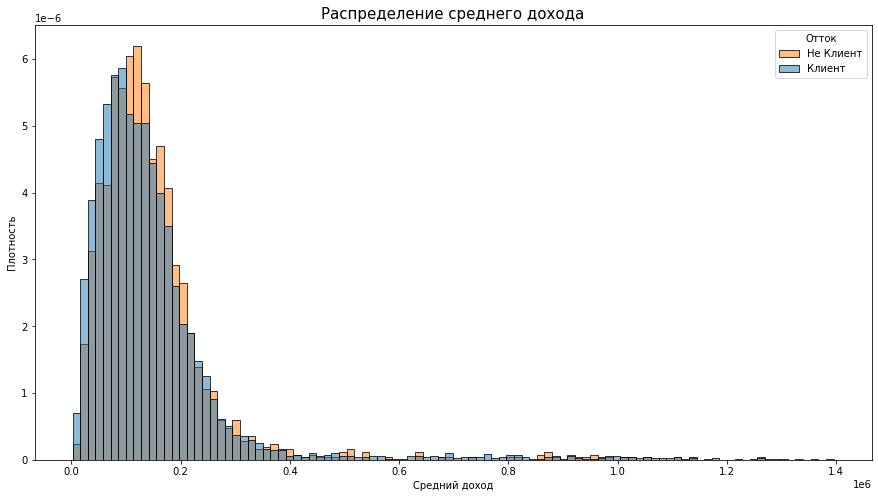

In [35]:
# построим еще раз гистограмму, чтобы посмотреть на распределение доходв

plt.figure(figsize=(15, 8))

sns.histplot(x = 'est_salary', hue = 'churn',data=data,stat="density",common_norm=False,bins=100)

plt.title('Распределение среднего дохода', fontsize=15)
plt.ylabel("Плотность")  
plt.xlabel("Средний доход")
plt.legend(['Не Клиент','Клиент'],title='Отток')

plt.show()

Мы еще раз подтвердили, что в признаке есть выбросы и он не имеет нормального распределения, поэтому для проверки гипотезы будем использовать тест Манна-Уитни.

Сформулируем одностроннюю гипотезу. 
- **Н0** - Нулевая гипотеза - средний доход по отточным/неотточным клиентам равен
- **Н1** - Альтернативная гипотеза - средний доход отточных клиентов выше, чем неотточных

In [36]:
alpha = 0.05

results = st. mannwhitneyu (data.query('churn == 1')['est_salary'], 
                            data.query('churn == 0')['est_salary'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 8.415364594114529e-05
Отвергаем нулевую гипотезу


**Вывод:** Средний доход отточных клиентов выше, чем неотточных

### Гипотеза о влиянии баланса клиентов на отток

В данном признаке тоже большое количество выбросов и не удовлетворяется условие о нормальном распределении, поэтому также используем Манна-Уитни
Сформулируем одностроннюю гипотезу. 
- **Н0** - Нулевая гипотеза - средние суммы баланса по отточным/неотточным клиентам равны
- **Н1** - Альтернативная гипотеза - средний баланс отточных клиентов выше, чем неотточных

In [37]:
#здесь используем ранее созданную базу без пропусков
alpha = 0.05

results = st. mannwhitneyu (data_balance.query('churn == 1')['balance'], 
                            data_balance.query('churn == 0')['balance'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 7.445581415996621e-71
Отвергаем нулевую гипотезу


**Вывод:** Баланс на счете отточных клиентов выше, чем неотточных

### Гипотеза о разнице в возрасте

Из исследовательского анализа мы видели, что средний возраст примерно одинаковый. Но для данной гипотезы возьмем клиентов с определенным количеством продуктов. Для начала посмотрим распределение по количеству продуктов.

In [38]:
data.groupby('products')['user_id'].count()

products
1    3323
2    5119
3    1038
4     474
5      19
Name: user_id, dtype: int64

Возьмем 2 самые крупные группы с 1 и 2 продуктами

In [39]:
# сформируем дату

data_product = data.query('products == 1 or products ==2')

In [40]:
# проверим условия для выбора теста
# размеры выборок

data_product.groupby('churn')['user_id'].count()

churn
0    7229
1    1213
Name: user_id, dtype: int64

Выборки имеют разный размер

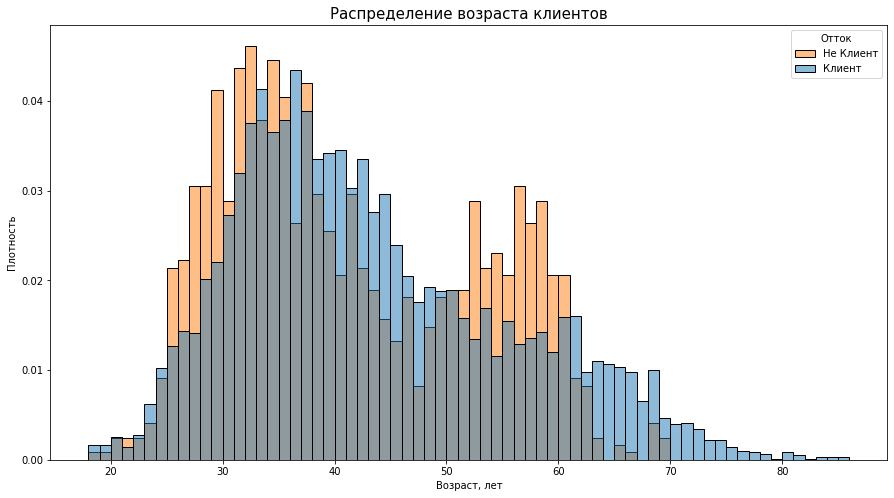

In [41]:
#проверим на нормальное распределение

plt.figure(figsize=(15, 8))

sns.histplot(x = 'age', hue = 'churn',data=data_product,stat="density",common_norm=False,binwidth=1)
plt.title('Распределение возраста клиентов', fontsize=15)
plt.ylabel("Плотность")  
plt.xlabel("Возраст, лет")
plt.legend(['Не Клиент','Клиент'],title='Отток')

plt.show()

Не отмечено явное нормальное распределение, поэтому проведем тест Шапиро для определения нормальности рапределения средних величин выборок в двух группах. Н0 - данные нормально распределены, Н1 - данные не имеют нормального распределения.

In [42]:
# по ушедшим клиентам, возьмем 500 случайных выборок по 1000 записей

means_churn = []
n = 1
while n < 500:
    n += 1
    sample = data_product[data_product['churn'] == 1].sample(1000)['age'].mean()
    means_churn.append(sample)

alpha = 0.05   

results = st.shapiro(means_churn)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.6492230892181396
Не получилось отвергнуть нулевую гипотезу


In [43]:
# по действующим клиентам, возьмем 500 случайных выборок по 1000 записей

means_no_churn = []
n = 1
while n < 500:
    n += 1
    sample = data_product[data_product['churn'] == 0].sample(1000)['age'].mean()
    means_no_churn.append(sample)

alpha = 0.05   

results = st.shapiro(means_no_churn)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.12532171607017517
Не получилось отвергнуть нулевую гипотезу


Проверим равенство дисперсий. Н0 - дисперсии равны, Н1 - дисперсии не равны

In [44]:
# выделим 2 случайные выборки и сравним

data_churn = data_product[data_product['churn'] == 1].sample(1000)['age']
data_no_churn = data_product[data_product['churn'] == 0].sample(1000)['age']

alpha = 0.05
results = st.levene(data_churn, data_no_churn)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.6092064055382849
Не получилось отвергнуть нулевую гипотезу


Условия проверены, можно проводить t-test. Сформулируем одностороннюю гипотезу
- **Н0** - Нулевая гипотеза - средний возраст клиентов с 1 или 2 продуктами по отточным и неотточным клиентам равны
- **Н1** - Альтернативная гипотеза - средний возраст отточных клиентов ниже, чем неотточных

In [45]:
# используем t-test

alpha = 0.05

results = st.ttest_ind(data_churn,
                      data_no_churn, alternative='less')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
#    equal_var = False 

p-значение: 0.0005041730223319725
Отвергаем нулевую гипотезу


**Вывод:** Возраст уходящих клиентов, имеющих 1 или 2 продукта, ниже

### Промежуточные выводы по результатам статистического анализа данных

Проведен статистический нализ данных и проверены 3 гипотезы. По результатам прверки гипотез можно сделать выводы:
- гипотеза о равенстве средних доходов по 2 группам клиентов не подтвердилась, доход ушедших клиентов в среднем выше
- гипотеза о равенстве средних сумм балансов на счете по 2 группам клиентов не подтвердилась, баланс на счете ушедших клиентов в среднем выше
- гипотеза о равенстве среднего возраста клиентов, имеющих 1 или 2 продукта не подтвердилась, возраст ушедших клиентов в среднем ниже.

## Сегментация

### Общие предпосылки

По результатам ИАД и САД отмечено, что есть более значимая зависимость между оттоком и доходом клиентов (интересный интервал от 110 до 210, когда отток превышает по графику, их балансом на счете (свыше 700 т.р.), активностью и количеством объектов собственности (от 3-х).
Кроме этого, мы отметили разницу в среднем возрасте клиентов, при этом выделены 2 интервала возрастов по ушедшим клиентам (26-36 и 50-60).
Количество продуктов по ушедшим клиентам начинается от 2.
К оттоку более склонны мужчины.
Формирование сегментов должно отвечать требованиям: уровень оттока в сегменте должен быть выше среднебанковского. Каждый сегмент должен включать не менее 500 клиентов.

In [46]:
# средний процент оттока

data['churn'].value_counts(normalize = True).reset_index()

,index,churn
0,0,0.82
1,1,0.18


### Сегмент 1 "Пол, возраст, средний доход"

Предыдущий анализ нам показал, что мужчины больше склонны к оттоку, чем женщины, проверим еще раз

In [47]:
# общее соотношение мужчин и женщин в базе данных

data['gender_code_М'].value_counts(normalize = True)

1   0.50
0   0.50
Name: gender_code_М, dtype: float64

In [48]:
# доля мужчин среди ушедших клиентов

data.query('churn == 1')['gender_code_М'].value_counts(normalize = True)

1   0.65
0   0.35
Name: gender_code_М, dtype: float64

Мужчин действительно больше. Теперь возьмем 2 показатели, по которым мы определили интервалы в распределении. Возраст - первый интервал от 26 до 36 и ср.доход от 110 до 210 т.р. Оценим размер сегмента, чтобы он удовлетворял критерию.

In [49]:
sgm_1_cnt = data.query('gender == "М" & 26 < age < 36 & 210000 > est_salary > 110000')['churn'].count()

sgm_1_cnt

570

Записей более 500, условие соблюдается, посмотрим процент оттока и запишем в переменную для дальнейше приоритизации

In [50]:
sgm_1_churn = data.query('gender == "М" & 26 < age < 36 & 210000 > est_salary > 110000')['churn'].value_counts(
    normalize = True)

sgm_1_churn

0   0.71
1   0.29
Name: churn, dtype: float64

**Вывод:** Сегмент 1 - молодой мужчина в возрасте от 26 до 36 лет со средним доходом от 110 до 210 тыс.руб. Процент оттока **29%**

### Сегмент 2 "2-ой интервал возраст, пол"

На распределении мы отметили еще один интервал по возрасту - от 50 до 60 лет. Посмотрим кто больше представлен в этом интервале мужчины или женщины.

In [51]:
data.query('60>age >50')['gender_code_Ж'].value_counts(normalize = True)

1   0.56
0   0.44
Name: gender_code_Ж, dtype: float64

Больше женщин, посмотрим количество записей

In [52]:
sgm_2_cnt = data.query('60>age >50')['gender_code_Ж'].sum()

sgm_2_cnt

790

In [53]:
#рассчитаем процент оттока

sgm_2_churn = data.query('gender == "Ж" & 60 > age > 50')['churn'].value_counts(
    normalize = True)

sgm_2_churn

0   0.77
1   0.23
Name: churn, dtype: float64

**Вывод:** Сегмент 2 - Женщина в возрасте от 50 до 60 лет. Процент оттока **23%**

### Сегмент 3 "Активность, баланс, собственность"

Рассмотрим в данном сегменте 3 наиболее влияющих фактора. Мы отметили ранее, что клиенты, имеющие баланс выше 700 тыс.руб. более склонны к оттоку, кроме этого активные клиенты. Также выяснили ранее, что склонны к оттоку клиенты, имеющие 3 и более объектов собственности. Посмотрим размер группы и процент оттока

In [54]:
# размер группы

sgm_3_cnt = data.query('balance > 700000 & equity >=3 & last_activity == 1')['churn'].count()

sgm_3_cnt

1386

In [55]:
# процент оттока

sgm_3_churn = data.query('balance > 700000 & equity >=3 & last_activity == 1')['churn'].value_counts(
    normalize = True)

sgm_3_churn

0   0.51
1   0.49
Name: churn, dtype: float64

**Вывод:** Сегмент 3 - Активный клиент с балансом на счете  свыше 700000 и объектами собственности от 3 и выше. Процент оттока **49%**

### Сегмент 4 "Активность, продукты, собственность"

Посмотрим на клиентов, которые имеют несколько продуктов, объектов собственности и при этом проявляют активность. Все эти признаки влияют на отток, узнаем, какой отток они дают в сочетании

In [56]:
# посмотрим на распределение количества продуктов, так как на гафике мы видели очень большой отток в том числе с 0 продуктами

data.groupby('products')['churn'].count()

products
1    3323
2    5119
3    1038
4     474
5      19
Name: churn, dtype: int64

Видим, что представлена только 1 запись по 0 продуктам, поэтому не будем ее учитывать. Напомним, что отток выше среднего наблюдается у клиентов с 2 и более продуктами.

In [57]:
# посмотрим размер сегмента по условиям

sgm_4_cnt = data.query('products >=2 & last_activity ==1 & equity>3')['churn'].count()

sgm_4_cnt

1833

In [58]:
# процент оттока
sgm_4_churn = data.query('products >=2 & last_activity ==1 & equity>3')['churn'].value_counts(
    normalize = True)

sgm_4_churn

0   0.59
1   0.41
Name: churn, dtype: float64

**Вывод:** Сегмент 4 - Активный клиент с 2-мя и более продуктами и объектами собственности от 3 и выше. Процент оттока **41%**

## Приоритизация сегментов

Соберем все данные в одну таблицу, чтобы сравнить их.

In [59]:
sgm_plus = pd.concat([sgm_1_churn,sgm_2_churn,sgm_3_churn,sgm_4_churn],axis=1)

sgm_plus.columns = ['s1','s2','s3','s4']
sgm_total = sgm_plus.T

sgm_total.columns = ['Клиент','Отток']

sgm_total['Кол-во'] = sgm_1_cnt,sgm_2_cnt,sgm_3_cnt,sgm_4_cnt

sgm_total.sort_values(by='Отток',ascending=False)

,Клиент,Отток,Кол-во
s3,0.51,0.49,1386
s4,0.59,0.41,1833
s1,0.71,0.29,570
s2,0.77,0.23,790


Данная таблица подойдет для маркетологов. Приоритизация проведена по проценту оттока. Здесь следует также обратить внимание на размер выборки. У 2-х сегментов с наибольшим процентом оттока количество клиентов в группе существенно выше, этоговорит о том, что мероприятия по данным сегментам дадут не только больший эффект в сокращении процента оттока по отдельной группе, но и в масштабе большем по клиентам.

## Итоговые выводы и рекомендации

На входе были получены данные о действующих и бывших клиентах "Метанпромбанка". 

В датасете было 10000 записей, поле обработки сократилось не существенно до 9974 записей.


Проведен исследовательский анализ данных. Его целью было с помощью разных инструментов найти признаки, которые больше влияют на отток клиентов. 
Для этого:
- было рассмотрено распределение значений (для непрерывных данных - интервалов) по всем признакам в разрезе текущих и ушедших клиентов
- рассмотрена корреляция всех признаков с признаком оттока
- а также составлены портреты клиентов (действующих и бывших) с описанием каждого признака и указанием относительной разницы значений по признакам

По итогам проведения исследовательского анализа выявлены признаки, которые наиболее существенно влияют на отток. Это активность клиента, баланс на счете, средний доход и количество объектов собственности. В меньшей степени, но тем не менее требующие внимания признаки - возраст, кол-во продуков, пол.

Далее был осуществлен статистический анализ данных и проверены 3 гипотезы. По результатам:
- гипотеза о равенстве средних доходов текущих и бывших клиентов не подтвердилась, доход у тех, кто ушел, выше
- гипотеза о равенстве среднего баланса на счете текущих и бывших клиентов не подтвердилась, баланс больше у тех, кто ушел
- гипотеза о равенстве среднего возраста текущих и бывших клиентов не подтвердилась, возраст ушедших ниже. НЕсмотря на то, что в портрете клиента разницы в среднем возрасте практически нет, мы отмечали ранее на распределении, что в графике есть 2 явных интервала.

Проверка гипотез и полученные результаты дополнили и подтвердили ранее полученные результаты.

В итоге на основе интервалов, полученных по распределению признаков, а также с учетом самых существенных признаков были сформированы 4 сегмента. Все они отвечают условиям: их размер более 500 клиентов, процент оттока по сегменту выше среднебанковского (18%).

2 сегмента из 4-х имеют уровень оттока выше 40% и достаточно большой размер групп (более 1000 клиентов), 2 других сегмента меньше (600-800 клиентов) и уровень оттока чуть ниже 23-29%, однако они тоже заслуживают внимания, так как предложенные  мероприятия по ним требуют меньших временных и материальных затрат и будут иметь более быстрый эффект.

**Рекомендации по сегментам:**

**Сегмент "Активный клиент с балансом на счете свыше 700000 и объектами собственности от 3 и выше".** Процент оттока **49%**
и **Сегмент "Активный клиент с 2-мя и более продуктами и объектами собственности от 3 и выше".** Процент оттока **41%**.
З
десь дадим общие рекомендации, так как эти сегменты частично пересекаются и похожи.Однозначно понятно, что сюда относятся обеспеченные клиенты, скорее всего постоянные, активно пользующиеся услугами банка и имеющие и несколько продуктов и объектов собственности. Их отток скорее всего связан с тем, что они уходят в более популярные или продвинутые банки с более интересными и широкими предложениями.Здесь требуется удержание таких клиентов, хорошим решением может стать введение  программы лояльности или премиальной программы  с персональным менеджером и дополнительными бонусами за количество используемых продуктов или сохранению (поддержанию на уровне) остатка баланса, золотыми и прочими картами с привилегиями. Также могут быть запущены дополнительные "околопродукты" по сниженным тарифам - например, страхование имущества, жизни, вкладов, путешествий и т.д. Рассмотреть бонусные программы с кэшбеком, например, на АЗС или такси. Клиенты с достатком обычно тратят достаточные суммы в месяц на транспорт и могут получить даже для них ощутимый кэшбек.

**Сегмент "Молодой мужчина в возрасте от 26 до 36 лет со средним доходом от 110 до 210 тыс.руб.** Процент оттока **29%**

Для молодых людей будут интересны программы кэшбека и сотрудничества с другими компаниями в виде скидок, спец.предложений). Так, например, сюда могут быть отнесены предложения по скидкам или сотрудничеству с приложениями (типа Музыка, Читалка, Кино), образовательные школы и курсы (языковые, ИТ и пр.) и определнной направленности магазины (электроника, спорт, компьютерные игры и пр.) Здесь более эффективным решением будет не просто кэшбек на категорию товаров, а именно сотрудничество с данными компаниями, то есть пока ты являешься клиентом Метанпромбанка, тебе бесплатно подписка или постоянная скида в магазин компьютерных игр и пр.

Самый небольшой **сегмент "Женщина в возрасте от 50 до 60 лет.** Процент оттока **23%**.
Но пожалуй самый быстро реализуемый. Здесь следует обратить внимание на то, что это женщины, а значит повышенный кэшбек и скидочная система на ктегории "Красота", "Одежда", "Магазин у дома". Кроме этого, это женщины в возрасте выше среднего, следует рассмотреть для них спец. предложения - вклады по возрасту, НПФ, страхование, программы ДМС. Кроме этого, женщины в данном возрасте начинают больше путешествовать, интересным станет сотрудничесиво и предложения с туристическими агентствами, экскурсионными бюро, системой РусПасс и все это с привязкой к карте "Мир" даст отличный результат.